# Análise da quantidade de itens de um projeto cultural
---

**Objetivo:** realizar uma análise comparativa entre a quantidade de itens de um projeto cultural específico com a quantidade de itens dos outros projetos culturais de um mesmo segmento. Nesta análise, será investigado se a quantidade de itens de um projeto é anormal com relação a quantidade de itens dos outros projetos do mesmo segmento.

#### Importando módulos necessários

In [1]:
%pylab inline
import pandas as pd
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


#### Carregando e mostrando dataset a ser utilizado ao longo do estudo

In [2]:
df = pd.read_csv('../../data/raw/planilha_orcamentaria.csv')
print(df.columns)
df.head()

Index(['idPronac', 'PRONAC', 'idPlanilhaAprovacao', 'Item', 'idPlanilhaItens',
       'Unidade', 'QtDias', 'QtItem', 'nrOcorrencia', 'VlUnitarioSolicitado',
       'VlTotalSolicitado', 'VlUnitarioAprovado', 'VlTotalAprovado', 'UfItem',
       'MunicipioItem', 'Etapa', 'idArea', 'Area', 'idSegmento', 'Segmento',
       'idProduto', 'Produto', 'DataProjeto', 'cdCidade', 'cdEtapa'],
      dtype='object')


,idPronac,PRONAC,idPlanilhaAprovacao,Item,idPlanilhaItens,Unidade,QtDias,QtItem,nrOcorrencia,VlUnitarioSolicitado,...,Etapa,idArea,Area,idSegmento,Segmento,idProduto,Produto,DataProjeto,cdCidade,cdEtapa
0,121051,100855,792860,Passagens Aéreas (Descrever os trechos na tela...,131,Unidade,150,40.0,1.0,150.0,...,2 - Produção / Execução,1,Artes Cênicas,11,Teatro,19,Espetáculo de Artes Cênicas,2010-02-19 11:53:49.387,330455,2
1,121051,100855,792883,Bonecos – Criação,3599,Verba,90,1.0,1.0,4000.0,...,2 - Produção / Execução,1,Artes Cênicas,11,Teatro,19,Espetáculo de Artes Cênicas,2010-02-19 11:53:49.387,330455,2
2,121051,100855,792903,Produtor executivo,53,Verba,90,3.0,1.0,3000.0,...,2 - Produção / Execução,1,Artes Cênicas,11,Teatro,19,Espetáculo de Artes Cênicas,2010-02-19 11:53:49.387,355030,2
3,119968,98671,109095,Assistente de produção,1037,Verba,30,1.0,1.0,1000.0,...,1 - Pré-Produção / Preparação,3,Música,31,Música Popular Cantada,51,Apresentação Musical,2009-12-28 11:37:57.830,330455,1
4,112836,91695,116511,Designer,103,Mês,378,1.0,18.0,2000.0,...,2 - Produção / Execução,7,Artes Integradas,71,Artes Integradas,17,Pesquisa,2009-05-21 10:48:48.790,431490,2


#### Gerando tabela com o número itens por projeto por segmento

In [3]:
num_items = df[['PRONAC', 'idSegmento', 'idPlanilhaAprovacao']].drop_duplicates()
num_items = num_items.groupby(['idSegmento', 'PRONAC']).count()
num_items = num_items.rename(columns={'idPlanilhaAprovacao': 'NumItems'})
num_items.head()

NumItems
idSegmento PRONAC          
11         90105         61
           97310         32
           98022         17
           100855        96
           102857        61

## Análise por segmento
---

Nesta etapa, analisaremos a quantidade de itens dos projetos para um segmento escolhido.

#### Esolhendo um segmento e gerando uma lista do número de itens para todos os projetos do segmento

In [4]:
segment = '11'
segment_projects = num_items.loc[segment]['NumItems']

#### Gerando gráfico dos dados acima

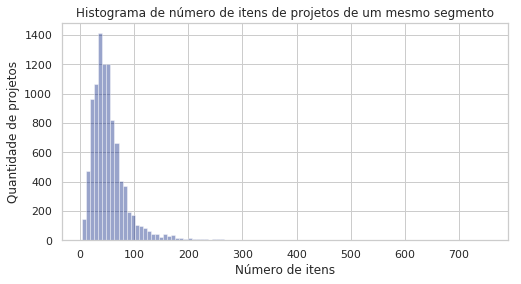

In [5]:
sns.set(style='whitegrid', palette='dark')
f, ax = plt.subplots(figsize=(8,4))

sns.distplot(segment_projects, bins=100, kde=False)
plt.title('Histograma de número de itens de projetos de um mesmo segmento')
plt.ylabel('Quantidade de projetos')
plt.xlabel('Número de itens')
plt.grid(True)

#### Separando os conjuntos de treino e teste

In [6]:
from sklearn.model_selection import train_test_split
projects_train, projects_test = train_test_split(segment_projects, test_size=0.3)

display(projects_train.head())
display(projects_test.head())

PRONAC
144575     56
160681     42
129751     46
102857     61
129693    108
Name: NumItems, dtype: int64

PRONAC
119362    45
119635    29
112583    38
150330    39
124395    53
Name: NumItems, dtype: int64

### Análise Gaussiana

In [7]:
import scipy

expected_mean = np.mean(projects_train)
expected_std = np.std(projects_train)
print('Média esperada: %.2lf' % expected_mean)
print('Desvio padrão esperado: %.2lf\n' % expected_std)

k = 1.8
lower_limit = expected_mean - k * expected_std
upper_limit = expected_mean + k * expected_std
contamination = 2 * (1 - scipy.stats.norm(expected_mean, expected_std).cdf(upper_limit))

inlier_filter = ((projects_test >= lower_limit) & (projects_test <= upper_limit))
contamination_found = sum(~inlier_filter) / len(projects_test)

print('Percentual de outliers esperado: %.2lf%%' % (100 * contamination))
print('Percentual de outliers encontrado: %.2lf%%' % (100 * contamination_found))

Média esperada: 55.07
Desvio padrão esperado: 41.53

Percentual de outliers esperado: 7.19%
Percentual de outliers encontrado: 3.51%


Text(0.5,1,'Inlier/Outlier division using Gaussian Estimation')

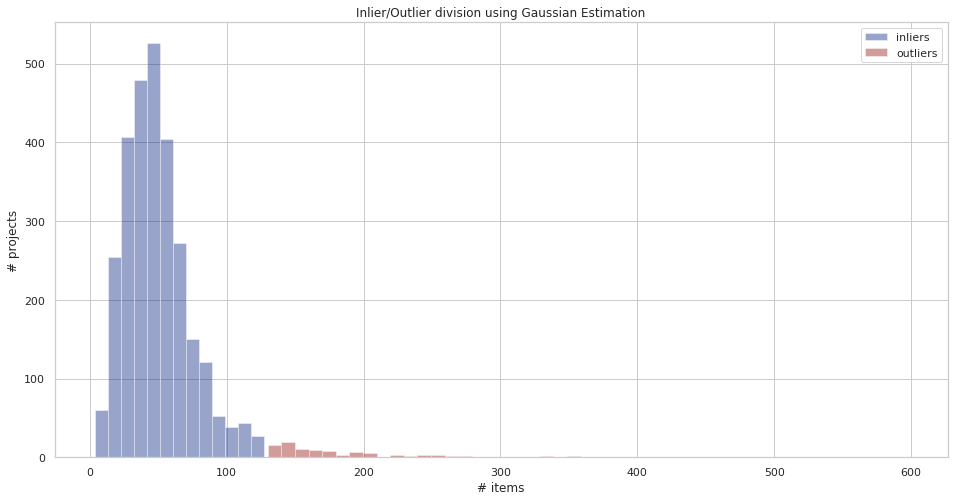

In [8]:
sns.set(style='whitegrid', palette='dark')
f, ax = plt.subplots(figsize=(16,8))

inliers = projects_test[inlier_filter].values
bins = max(1, (max(inliers) - min(inliers)) // 10 + 1)
sns.distplot(inliers, label="inliers", color="b", kde=False, bins=bins)

outliers = projects_test[~inlier_filter].values
bins = max(1, (max(outliers) - min(outliers)) // 10 + 1)
sns.distplot(outliers, label="outliers", color="r", kde=False, bins=bins)

plt.legend(frameon=True)
plt.ylabel('# projects')
plt.xlabel('# items')
plt.title('Inlier/Outlier division using Gaussian Estimation')

### Análise LOF

In [9]:
def to_2D(x):
    ''' Given a pd.Series, return a "2D" np.Array with zeros in one dimension.
    '''
    shape = (len(x),1)
    return np.hstack([np.array(x.tolist()).reshape(shape), np.zeros(shape)])

In [10]:
from sklearn.neighbors import LocalOutlierFactor

# Same expected outliers percentual as gaussian method
contamination = 2 * (1 - scipy.stats.norm(0,1).cdf(k))

# Work well for LOF
n_neighbors = 20 # max(20, int(len(projects_train)/100))

# Convert sets to LOF standard
X_train = to_2D(projects_train)
X_test = to_2D(projects_test)

# Get inliers of the training set with LOF Outlier Detection
lof_OD = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)
y_train = lof_OD.fit_predict(X_train)
X_train = X_train[y_train == 1, :]

# Train model with LOF Novelty Detection, using train set inliers
# Parameter 'contamination' does not matter at this point
lof_ND = LocalOutlierFactor(novelty=True, contamination=0.5)
lof_ND = lof_ND.fit(X_train)

# Predict outliers from test set
y_test = lof_ND.predict(X_test)
inlier_filter = (y_test == 1)

# Output results
contamination_found = sum(~inlier_filter) / len(projects_test)
print('Percentual de outliers esperado: %.2lf%%' % (100 * contamination))
print('Percentual de outliers encontrado: %.2lf%%' % (100 * contamination_found))

Percentual de outliers esperado: 7.19%
Percentual de outliers encontrado: 6.36%


Text(0.5,1,'Inlier/Outlier division using LOF Estimation')

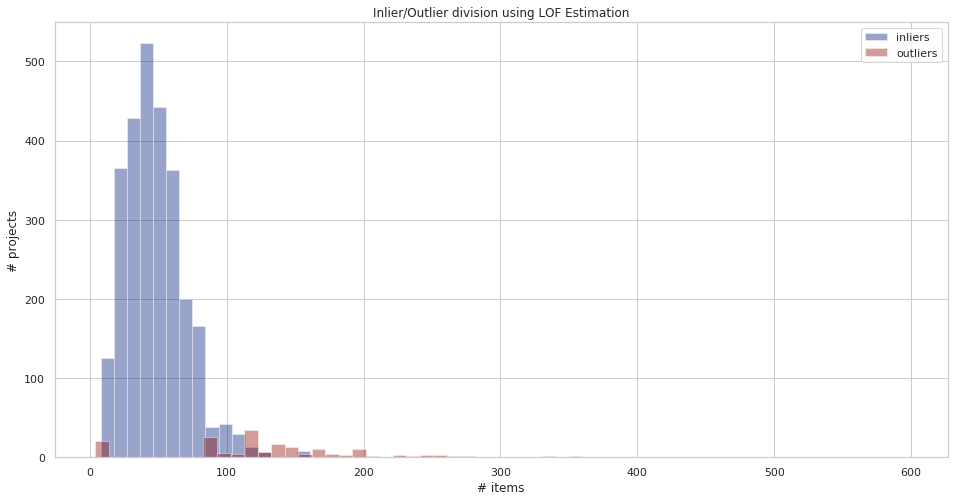

In [11]:
sns.set(style='whitegrid', palette='dark')
f, ax = plt.subplots(figsize=(16,8))

inliers = projects_test[inlier_filter].values
bins = max(1, (max(inliers) - min(inliers)) // 10 + 1)
sns.distplot(inliers, label="inliers", color="b", kde=False, bins=bins)

outliers = projects_test[~inlier_filter].values
bins = max(1, (max(outliers) - min(outliers)) // 10 + 1)
sns.distplot(outliers, label="outliers", color="r", kde=False, bins=bins)

plt.legend(frameon=True)
plt.ylabel('# projects')
plt.xlabel('# items')
plt.title('Inlier/Outlier division using LOF Estimation')

### Avaliando a contaminação para cada um dos métodos

Nesta seção, os métodos Gaussiano e LOF são aplicados a 100 escolhas diferentes de conjuntos de treino/teste. Ao final, o desempenho de cada método é avaliado.

In [12]:
percentuals = {'gaussian': [], 'lof': []}

for i in range(100):
    # Separate train and test sets
    projects_train, projects_test = train_test_split(segment_projects, test_size=0.3)
    
    # Parameters
    k = 1.8
    contamination = 2 * (1 - scipy.stats.norm(expected_mean, expected_std).cdf(upper_limit))

    # GAUSSIAN
    lower_limit = expected_mean - k * expected_std
    upper_limit = expected_mean + k * expected_std
    inlier_filter = ((projects_test >= lower_limit) & (projects_test <= upper_limit))
    
    contamination_found = sum(~inlier_filter) / len(projects_test)
    percentuals['gaussian'].append(100 * contamination_found)
    
    # LOF
    # Working well for LOF
    n_neighbors = 20 # max(20, int(len(projects_train)/100))

    # Convert sets to LOF standard
    X_train = to_2D(projects_train)
    X_test = to_2D(projects_test)

    # Get inliers of the training set with LOF Outlier Detection
    lof_OD = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=0.5)
    y_train = lof_OD.fit_predict(X_train)
    X_train = X_train[y_train == 1, :]

    # Train model with LOF Novelty Detection, using train set inliers
    lof_ND = LocalOutlierFactor(novelty=True, contamination=contamination)
    lof_ND = lof_ND.fit(X_train)

    # Predict outliers from test set
    y_test = lof_ND.predict(X_test)
    inlier_filter = (y_test == 1)
    
    contamination_found = sum(~inlier_filter) / len(projects_test)
    percentuals['lof'].append(100 * contamination_found)

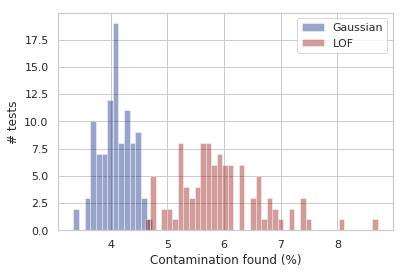

In [13]:
sns.set(style='whitegrid', palette='dark')

gauss = percentuals['gaussian']
bins = max(1, int((max(gauss) - min(gauss)) * 10) + 1)
sns.distplot(gauss, label="Gaussian", color="b", kde=False, bins=bins)

lof = percentuals['lof']
bins = max(1, int((max(lof) - min(lof)) * 10) + 1)
sns.distplot(lof, label="LOF", color="r", kde=False, bins=bins)

# plt.hist(percentuals['gaussian'], bins=20, label='Gaussian')
# plt.hist(percentuals['lof'], bins=20, label='LOF')

plt.legend(frameon=True)
plt.xlabel('Contamination found (%)')
plt.ylabel('# tests')
plt.grid(True)

#### Conclusões

Mesmo com um dataset com distribuição próxima a uma Gaussiana, o percentual de contaminação encontrado pelo LOF se mostrou mais próximo do valor esperado que a estimação de contaminação encontrada pela Gaussiana.

Outro ponto importante a se notar é a marcação de projetos como inlier/outlier em ambos os estimadores. Na estimação Gaussiana, os projetos são marcados como outlier apenas se a quantidade de itens deste projeto está fora de um intervalo de valores aceitáveis. Já no estimador LOF, se um projeto tem uma quantidade específica de itens que é menos comum relativamente que seus vizinhos (projetos com uma quantidade parecida de itens), então o projeto pode ser marcado como outlier, o que não parece fazer sentido neste contexto.

Exemplo: suponha que exista um único projeto com 100 itens, porém, vários com 99 e com 101. Utilizando o estimador LOF, este projeto poderá ser marcado como outlier.